# **Titanic - Machine Learning from Disaster**
* Added Features: Name Prefix, Age Category, Family Size
* Classifier Used: XGBoost
* Hyper-Parameters optimized using GridSearch: learning_rate, n_estimators, max_depth
* Used **pipelines** to improve the efficiency of machine learning code

## Contents:
1. **X, y Dataframes Creation**
2. **X, y Summary**
3. **Data Cleaning**
4. **Feature Engineering**
5. **Data Visualization**
6. **Feature Selection**
7. **Model Creation**
8. **Training and Testing Model**
9. **Predicting y**

# 1) X, y Dataframes Creation

## Import Data Analytics libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import Machine Learning Libraries

In [2]:
from sklearn.pipeline import Pipeline

# To perform operations on columns:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ML algorithms:
from xgboost import XGBClassifier

# To evaluate performance model:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Get file paths

In [3]:
# Running this will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Read the data

In [4]:
X_y = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
X_test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')

##  Separate target from predictors

In [5]:
# First remove rows with missing target
X_y = X_y.dropna(axis=0, subset=['Survived'])

y = X_y.Survived
X = X_y.drop(['Survived'], axis=1)

# 2) X, y Summary

In [6]:
X.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [9]:
y.head(2)

PassengerId
1    0
2    1
Name: Survived, dtype: int64

In [10]:
y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

# 3) Data Cleaning

## Remove the columns with more than half missing values

In [11]:
null_values = X.isnull().sum()
null_values[null_values>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [12]:
null_values_test = X_test.isnull().sum()
null_values_test[null_values_test>0]

Age       86
Fare       1
Cabin    327
dtype: int64

In [13]:
null_columns = [col for col in X.columns if X[col].isnull().sum() > X.shape[0]/2]
null_columns

['Cabin']

In [14]:
X = X.drop(null_columns, axis=1)
X_test = X_test.drop(null_columns, axis=1)

## Casting Sex data type (from object to category)

In [15]:
X['Sex'] = X['Sex'].astype("category")
X_test['Sex'] = X_test['Sex'].astype("category")

In [16]:
X.Sex.dtype

CategoricalDtype(categories=['female', 'male'], ordered=False)

# 4) Feature Engineering

## 4.1) Name Prefix

In [17]:
X['Prefix'] = X['Name'].str.split(expand=True)[1]
X_test['Prefix'] = X_test['Name'].str.split(expand=True)[1]

In [18]:
prefixes = X.Prefix.value_counts()
top_prefixes = prefixes[prefixes>len(X)/25].index
top_prefixes

Index(['Mr.', 'Miss.', 'Mrs.', 'Master.'], dtype='object')

In [19]:
X.Prefix = X.Prefix.apply(lambda x: x if x in top_prefixes else 'other')
X.Prefix.value_counts()

Mr.        502
Miss.      179
Mrs.       121
other       49
Master.     40
Name: Prefix, dtype: int64

In [20]:
X_test.Prefix = X_test.Prefix.apply(lambda x: x if x in top_prefixes else 'other')
X_test.Prefix.value_counts()

Mr.        234
Miss.       77
Mrs.        70
Master.     19
other       18
Name: Prefix, dtype: int64

## Imputing Age (using group means)

In [21]:
print(X["Age"].isnull().sum(),X_test["Age"].isnull().sum())

177 86


In [22]:
avg_ages = X.groupby(['Prefix','Sex','Pclass'])['Age'].mean()
avg_ages

Prefix   Sex     Pclass
Master.  female  1               NaN
                 2               NaN
                 3               NaN
         male    1          5.306667
                 2          2.258889
                 3          5.350833
Miss.    female  1         30.000000
                 2         22.241935
                 3         16.186567
         male    1               NaN
                 2               NaN
                 3               NaN
Mr.      female  1               NaN
                 2               NaN
                 3               NaN
         male    1         41.629412
                 2         32.814815
                 3         28.646119
Mrs.     female  1         41.606061
                 2         33.682927
                 3         33.633333
         male    1               NaN
                 2               NaN
                 3               NaN
other    female  1         31.285714
                 2         27.500000
              

In [23]:
for i in X.Prefix.unique():
    for j in X.Sex.unique():
        for k in X.Pclass.unique():
            value=avg_ages.loc[i,j,k]
            X.loc[(X.Prefix==i) & (X.Sex==j) & (X.Pclass==k) & (X.Age.isnull()), ['Age']] = value
            X_test.loc[(X_test.Prefix==i) & (X_test.Sex==j) & (X_test.Pclass==k) & (X_test.Age.isnull()), ['Age']] = value

In [24]:
print(X["Age"].isnull().sum(),X_test["Age"].isnull().sum())

0 0


## 4.2) Age Category

In [25]:
def Age_categorise(df):
    df['Age_Cat'] = pd.cut(df.Age,
                         bins = [0, 10, 40, 60, 100],
                         labels = ['child', 'young', 'adult', 'senior'])
    
Age_categorise(X)
Age_categorise(X_test)

In [26]:
X['Age_Cat'].dtype

CategoricalDtype(categories=['child', 'young', 'adult', 'senior'], ordered=True)

In [27]:
X['Age_Cat'].value_counts()

young     643
adult     158
child      68
senior     22
Name: Age_Cat, dtype: int64

In [28]:
X_test['Age_Cat'].value_counts()

young     307
adult      75
child      25
senior     11
Name: Age_Cat, dtype: int64

In [29]:
X.Age_Cat.isnull().sum()

0

## 4.3) Fare Category

In [30]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [31]:
def Fare_categorise(df):
    df['Fare_Cat'] = pd.qcut(df.Fare,
                         q=4,
                         labels = ['low', 'medium', 'high', 'very_high'])
    
Fare_categorise(X)
Fare_categorise(X_test)

In [32]:
X['Fare_Cat'].dtype

CategoricalDtype(categories=['low', 'medium', 'high', 'very_high'], ordered=True)

In [33]:
X['Fare_Cat'].value_counts()

medium       224
low          223
high         222
very_high    222
Name: Fare_Cat, dtype: int64

In [34]:
X_test['Fare_Cat'].value_counts()

low          114
high         105
very_high    102
medium        96
Name: Fare_Cat, dtype: int64

## 4.4) Family Size

In [35]:
X['Family'] = X['SibSp'] + X['Parch']
X_test['Family'] = X_test['SibSp'] + X_test['Parch']

X = X.drop(['SibSp','Parch'],axis=1)
X_test = X_test.drop(['SibSp','Parch'],axis=1)

In [36]:
X.Family.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [37]:
def Categorize_Family(df):
    df['Family_Size'] = pd.cut(df.Family,
                         bins = [-1, .5, 2.5, 12],
                         labels = ['alone', 'medium', 'large'])
    
Categorize_Family(X)
Categorize_Family(X_test)

In [38]:
X.Family_Size.value_counts()

alone     537
medium    263
large      91
Name: Family_Size, dtype: int64

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       891 non-null    int64   
 1   Name         891 non-null    object  
 2   Sex          891 non-null    category
 3   Age          891 non-null    float64 
 4   Ticket       891 non-null    object  
 5   Fare         891 non-null    float64 
 6   Embarked     889 non-null    object  
 7   Prefix       891 non-null    object  
 8   Age_Cat      891 non-null    category
 9   Fare_Cat     891 non-null    category
 10  Family       891 non-null    int64   
 11  Family_Size  891 non-null    category
dtypes: category(4), float64(2), int64(2), object(4)
memory usage: 66.8+ KB


In [40]:
X.isnull().sum()

Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Embarked       2
Prefix         0
Age_Cat        0
Fare_Cat       0
Family         0
Family_Size    0
dtype: int64

In [41]:
X_test.isnull().sum()

Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           1
Embarked       0
Prefix         0
Age_Cat        0
Fare_Cat       1
Family         0
Family_Size    0
dtype: int64

## Making ordered categories into numerical data

In [42]:
X.dtypes.value_counts()

object      4
int64       2
float64     2
category    1
category    1
category    1
category    1
dtype: int64

In [43]:
ordinal_cols = X.select_dtypes(include=['category']).columns
ordinal_cols

Index(['Sex', 'Age_Cat', 'Fare_Cat', 'Family_Size'], dtype='object')

In [44]:
X.loc[:,'Age_Cat'] = X.loc[:,'Age_Cat'].replace(['child', 'young', 'adult', 'senior'], [0,1,2,3])
X_test.loc[:,'Age_Cat'] = X_test.loc[:,'Age_Cat'].replace(['child', 'young', 'adult', 'senior'], [0,1,2,3])

In [45]:
X.loc[:,'Fare_Cat'] = X.loc[:,'Fare_Cat'].replace(['low', 'medium', 'high', 'very_high'], [0,1,2,3])
X_test.loc[:,'Fare_Cat'] = X_test.loc[:,'Fare_Cat'].replace(['low', 'medium', 'high', 'very_high'], [0,1,2,3])

In [46]:
X.loc[:,'Family_Size'] = X.loc[:,'Family_Size'].replace(['alone', 'medium', 'large'], [0,1,2])
X_test.loc[:,'Family_Size'] = X_test.loc[:,'Family_Size'].replace(['alone', 'medium', 'large'], [0,1,2])

# 5) Data Visualization

In [47]:
Xy = X.copy()
Xy['Survived'] = y.copy()

In [48]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100, "figure.autolayout":True, 'axes.titlesize':10})

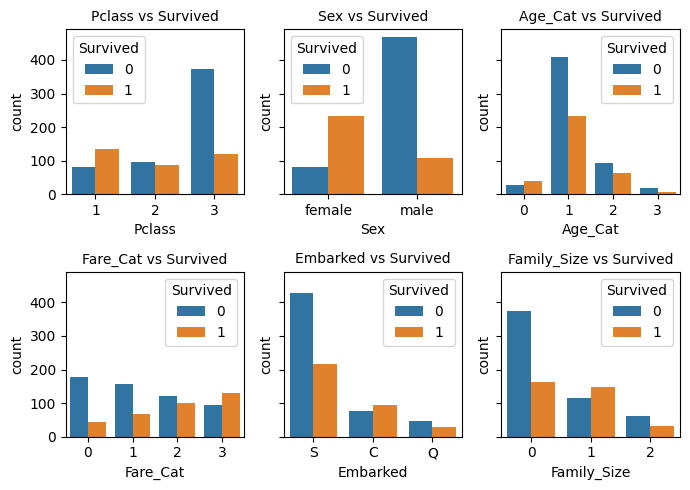

In [49]:
l=['Pclass','Sex','Age_Cat','Fare_Cat','Embarked','Family_Size']
figure, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=False)
index = 0
axes = axes.flatten()
for axis in axes:
    sns.countplot(x = l[index], hue = "Survived", data = Xy, ax=axis)
    axis.set_title(l[index]+' vs Survived')
    index = index+1
plt.show()

# 6) Feature Selection

In [50]:
# Fare_Cat column will be sufficient to find the trend. So, drop Fare column.
X = X.drop(['Age','Fare','Family','Prefix','Embarked'],axis=1)
X_test = X_test.drop(['Age','Fare','Family','Prefix','Embarked'],axis=1)

In [51]:
# Select categorical columns with low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X.columns 
                    if X[cname].nunique() < 10 and
                    X[cname].dtype in ["object","category"]]

In [52]:
# Select numerical columns
numerical_cols = [cname for cname in X.columns 
                  if X[cname].dtype in ['int64', 'float64']]

In [53]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X = X[my_cols]
X_test = X_test[my_cols]

In [54]:
print(len(categorical_cols),len(numerical_cols))

1 4


In [55]:
# Final features on which Model will be trained
X.dtypes.value_counts()

int64       4
category    1
dtype: int64

In [56]:
X.columns

Index(['Sex', 'Pclass', 'Age_Cat', 'Fare_Cat', 'Family_Size'], dtype='object')

In [57]:
X_test.head(2)

,Sex,Pclass,Age_Cat,Fare_Cat,Family_Size
PassengerId,,,,,
892,male,3,1,0.0,0
893,female,3,2,0.0,1


# 7) Model Creation

## Preprocessing Pipelines

In [58]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

In [59]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [60]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Model Pipeline

In [61]:
# Create object of XGBClassifier class
xgb = XGBClassifier()

# Bundle preprocessing and modeling code in a pipeline
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

## Visualize the pipeline

In [62]:
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age_Cat',
                                                   'Fare_Cat', 'Family_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callback...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

# 8) Training and Testing Model

## Grid Search & Cross Validation

In [63]:
# Hyper-Parameters that can be optimised using GridSearch
classifier.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__add_indicator', 'preprocessor__num__copy', 'preprocessor__num__fill_value', 'preprocessor__num__missing_values', 'preprocessor__num__strategy', 'preprocessor__num__verbose', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__onehot', 'preprocessor__cat__imputer__add_indicator', 'preprocessor__cat__imputer__copy', 'preprocessor__cat__imputer__fill_value', 'preprocessor__cat__imputer__missing_values', 'preprocessor__cat__imputer__strategy', 'preprocessor__cat__imputer__verbose', 'preprocessor__cat__onehot__categories', 'preprocessor__cat__onehot__drop', 'preproc

In [64]:
param_grid = [
    {        
        "model__learning_rate": [0.05, 0.1, .2],
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [4, 5, 6]
    }
]
grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=1)
grid_search.fit(X, y);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [65]:
print("Best params:",grid_search.best_params_,sep='\t')
print("Best score in grid search:",round(grid_search.best_score_,3),sep='\t')
print("Score on whole trained data:",round(grid_search.score(X, y),3),sep='\t')

Best params:	{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Best score in grid search:	0.834
Score on whole trained data:	0.853


## Confusion Matrix (for trained data)

In [66]:
y_pred = grid_search.predict(X)
cm = confusion_matrix(y, y_pred)
print(cm)
round(accuracy_score(y, y_pred),3)

[[510  39]
 [ 92 250]]


0.853

## Classification Report

In [67]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       549
           1       0.87      0.73      0.79       342

    accuracy                           0.85       891
   macro avg       0.86      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



# 9) Predicting y

In [68]:
# Generate test predictions
preds_test = grid_search.predict(X_test)

In [69]:
# Save output to CSV file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': preds_test})
output.to_csv('submission.csv', index=False)

In [70]:
# Submit results
submission_data = pd.read_csv("submission.csv")
submission_data.head(2)

,PassengerId,Survived
0,892,0
1,893,0
